### Importing required libraries

In [1]:
from src.utils import heart_slice, plot_function, plot_vector_field
from src.models.dynamics_models import BidomainModel
from src.models.cell_models import *
import ufl

### Defining a domain, cell model and the whole model and visualizing initial data

In [2]:
domain = heart_slice()
cell_model = Noble(domain=domain)
x = ufl.SpatialCoordinate(domain)


class Model(BidomainModel):
    def initial_V_m(self):
        def value(x): 
            return -84 + 24*np.exp(-(x[0]-0)** 2 + -(x[1]-2.7) ** 2)
        self.V_m_n.interpolate(value)

    def conductivity(
        self,
        longitudinal_fibres=[
            x[1] / (x[0] ** 2 + x[1] ** 2),
            -x[0] / (x[0] ** 2 + x[1] ** 2),
        ],
        transversal_fibres=[0, 0],
    ):
        return super().conductivity(longitudinal_fibres, transversal_fibres)

    def ischemia(self):
        return (
            lambda x: (x[0] - 2) ** 2 / 10 + (x[1] - 1.2) ** 2 < 0.4**2,
            self.M_i / 10,
            self.M_e / 10,
        )


model = Model(domain, cell_model)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Nurb)
Info    : [ 40%] Meshing curve 2 (Nurb)
Info    : [ 70%] Meshing curve 3 (Nurb)
Info    : Done meshing 1D (Wall 0.0842659s, CPU 0.080243s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.229465s, CPU 0.230498s)
Info    : Meshing 3D...
Info    : Done meshing 3D (Wall 5.1004e-05s, CPU 3.4e-05s)
Info    : 3946 nodes 7867 elements


In [3]:
model.plot_initial_V_m(show_mesh=False)

Widget(value='<iframe src="http://localhost:39893/index.html?ui=P_0x7f9f28b2f990_0&reconnect=auto" class="pyvi…

In [6]:
model.plot_ischemia(show_mesh=False)

Widget(value='<iframe src="http://localhost:39085/index.html?ui=P_0x7f945d97b750_1&reconnect=auto" class="pyvi…

In [5]:
x_c, y_c = 0, 0.8
plot_vector_field(
    domain,
    lambda x: [
        (x[1] - y_c) / ((x[0] - x_c) ** 2 + (x[1] - y_c) ** 2),
        -(x[0] - x_c) / ((x[0] - x_c) ** 2 + (x[1] - y_c) ** 2),
        0,
    ],
    tolerance=0.03,
    factor=1,
)

Widget(value='<iframe src="http://localhost:39755/index.html?ui=P_0x7fc692adfc90_2&reconnect=auto" class="pyvi…

### Solving equations with given parameters

In [6]:
model.solve(
    T=1000,
    steps=2000,
    save_to="demo.mp4",
    signal_point=[-2.0, 1.0, 0.0],
)

Solving problem: 100%|██████████| 2000/2000 [26:17<00:00,  1.27it/s]


### Plotting a final plot of transmembrane potential

In [10]:
plot_function(model.V_m_n, "V_m",show_mesh=False)

Widget(value='<iframe src="http://localhost:39755/index.html?ui=P_0x7fc6f047ac90_4&reconnect=auto" class="pyvi…

### Plotting a transmembrane potential in a given signal point

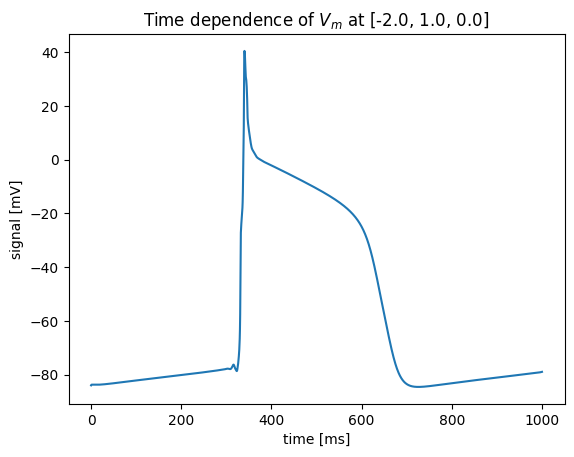

In [11]:
model.plot_signal()

### Plotting a transmembrane potential solution of a cell model

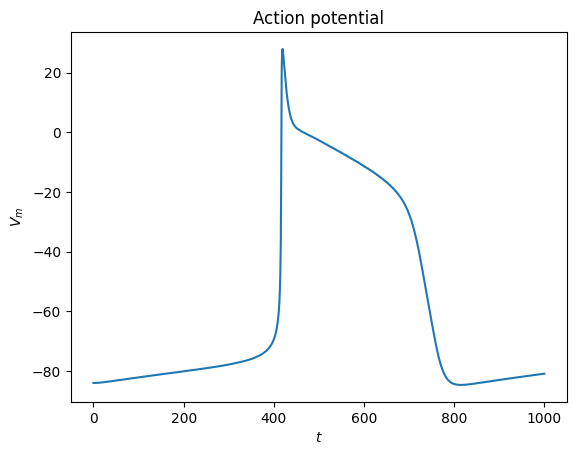

U trenutku t= 1000  -- V, m, h i n iznose: -80.90416246663271 0.04506845530084282 0.8464425965281648 0.45667287730468


In [12]:
cell_model.visualize(1000, -84)